# How to run this notebook

1. Download all-full.csv, container.csv and model1 from google drive
2. Upper left corner > Runtime > run all
3. Go into first cell and choose to upload the three files. This will take a minute.
4. Wait for all cells to complete running. Cells are competed when there is no spinning run button.

## Set up

In [2]:
from google.colab import files
# choose to upload all-full.csv and container.csv and model1
uploaded = files.upload()
%ls


Saving all-full.csv to all-full.csv
Saving container.csv to container.csv
Saving model1 to model1
all-full.csv  container.csv  model1  sample_data/


In [3]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn import metrics
import numpy as np
import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import gensim.downloader as api

info = api.info()  # show info about available models/datasets
model_google_news = api.load("word2vec-google-news-300")


[=================================================-] 98.4% 1635.5/1662.8MB downloaded


In [4]:
def load_logistic_regression_data():
  text = np.genfromtxt('container.csv', delimiter=",", dtype=None, encoding=None)
  labels = np.genfromtxt('all-full.csv', delimiter=",", usecols=0, skip_header=1)
  w2v = gensim.models.word2vec.Word2Vec.load('model1') 
  return text, labels, w2v.wv

In [5]:
def document_vector(doc, w2v_model):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in w2v_model.vocab]
    return np.mean(w2v[doc], axis=0)

def document_vector_news(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in model_google_news.vocab]
    return np.mean(model_google_news[doc], axis=0)

In [6]:
# load data & model
text, label, w2v = load_logistic_regression_data()

# split data in to test & train
train, test, label_train, label_test = train_test_split(text, label, test_size=0.2)

# setup w2v word matrices
w2v_train = []
w2v_test = []
for t in train:
  w2v_train.append(document_vector(t, w2v))
for t in test:
  w2v_test.append(document_vector(t, w2v))

# setup w2v word matrices
w2v_train_news = []
w2v_test_news = []
for t in train:
  w2v_train_news.append(document_vector_news(t))
for t in test:
  w2v_test_news.append(document_vector_news(t))

# setup sklearn count matrices
vectorizer = CountVectorizer(min_df=10)
X_train = vectorizer.fit_transform(train)
X_test = vectorizer.transform(test)


['international electronic industry company elcoteq laid tens employees tallinn facility contrary earlier layoffs company contracted ranks office workers daily postimees reported'
 'new production plant company would increase capacity meet expected increase demand would improve use raw materials therefore increase production profitability'
 'according company updated strategy years basware targets long term net sales growth range operating profit margin net sales'
 ...
 'result transactions aggregate holdings burrill life sciences capital fund l p went per cent overall number shares votes corporation'
 'notified result corporation issuing new shares directed offering joint holdings pequot went overall number shares votes corporation'
 'comparable operating profit overalled eur mn eur mn corresponding period representing net sales']


## Model training

### Count vectorization

#### Logistic regression model using count vectorization

In [49]:
# Fit to logistic regression using count vectors
# cross validation of lambda values (regularization strength)

lambda_val = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1]
lrcv = sklearn.linear_model.LogisticRegressionCV(penalty="l2", Cs=lambda_val, cv=5)
lrcv.fit(X_train, label_train)

y_lrcv_pred = lrcv.predict(X_test)
lr_accuracy = metrics.accuracy_score(label_test, y_lrcv_pred)

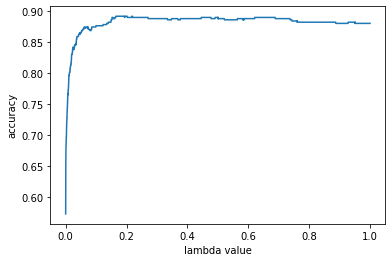

0.5884615384615385 0.5892000000000001


In [64]:
lambda_val = np.arange(0.0001, 1, 0.0001)
accuracies = []
cur_best_lv_cv = 0
cur_best_accu_cv = 0
best_lr_cv = sklearn.linear_model.LogisticRegressionCV(penalty="l2", Cs=lambda_val, cv=5)
for lv in lambda_val:
  lr = sklearn.linear_model.LogisticRegression(penalty="l2", C=lv)
  lr.fit(X_train, label_train)
  accu = lr.score(X_test, label_test)
  accuracies.append(accu)
  if accu > cur_best_accu_cv:
    cur_best_accu_cv = accu
    cur_best_lv_cv = lv
    best_lr_cv = lr
    
plt.plot(lambda_val, accuracies)
plt.ylabel('accuracy')
plt.xlabel('lambda value')
plt.show()

print(cur_best_accu, cur_best_lv)

#### Random Forst classifier using count vectorization

In [51]:
# Fit to random forest using count vectors
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, label_train)

y_rf_pred = clf.predict(X_test)
rf_accu = metrics.accuracy_score(label_test, y_rf_pred)

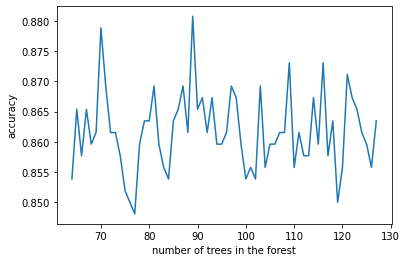

89 0.8807692307692307


In [65]:
# Fit to random forest using w2v vectors
estimators = np.arange(64, 128, 1)
accuracies = []
cur_best_e_cv = 0
cur_best_accu_rf_cv = 0
best_rf_cv = RandomForestClassifier(n_estimators=1)
for e in estimators:
  rf = RandomForestClassifier(n_estimators=e)
  rf.fit(X_train, label_train)
  y_p = rf.predict(X_test)
  accu = metrics.accuracy_score(label_test, y_p)
  accuracies.append(accu)
  if accu > cur_best_accu_rf_cv:
    cur_best_accu_rf_cv = accu
    cur_best_e_cv = e
    best_rf_cv = rf
    
plt.plot(estimators, accuracies)
plt.ylabel('accuracy')
plt.xlabel('number of trees in the forest')
plt.show()

print(cur_best_e_cv, cur_best_accu_rf_cv)

### Word2Vec Vectorization

#### Logistic regression model using word2vec vectorization

In [53]:
# Fit to logistic regression using w2v matrices
lambda_val = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1]
lrcv_w2v = sklearn.linear_model.LogisticRegressionCV(penalty="l2", Cs=lambda_val, cv=5)
lrcv_w2v.fit(w2v_train, label_train)

y_lrcvw_pred = lrcv_w2v.predict(w2v_test)
lrw_accuracy = metrics.accuracy_score(label_test, y_lrcvw_pred)

0.5884615384615385 0.59


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

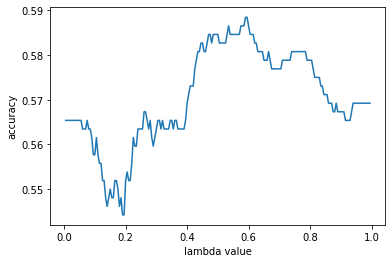

In [90]:
# CV with plot
lambda_val = np.arange(0.005, 1, 0.005)
accuracies = []
cur_best_lv = 0
cur_best_accu = 0
best_lr = sklearn.linear_model.LogisticRegressionCV(penalty="l2", Cs=lambda_val, cv=5)
for lv in lambda_val:
  lr = sklearn.linear_model.LogisticRegression(penalty="l2", C=lv)
  lr.fit(w2v_train, label_train)
  accu = lr.score(w2v_test, label_test)
  accuracies.append(accu)
  if accu > cur_best_accu:
    cur_best_accu = accu
    cur_best_lv = lv
    best_lr = lr
    
plt.plot(lambda_val, accuracies)
plt.ylabel('accuracy')
plt.xlabel('lambda value')
# plt.show()

print(cur_best_accu, cur_best_lv)
plt.savefig("LR_Hyperparam.png")
files.download("LR_Hyperparam.png")


In [55]:
# Fit to logistic regression using w2v matrices
lambda_val = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1]
lrcv_w2v_news = sklearn.linear_model.LogisticRegressionCV(penalty="l2", Cs=lambda_val, cv=5)
lrcv_w2v_news.fit(w2v_train_news, label_train)

y_lrcvw_news_pred = lrcv_w2v_news.predict(w2v_test_news)
lrw_news_accuracy = metrics.accuracy_score(label_test, y_lrcvw_news_pred)

In [56]:
# CV with plot
lambda_val = np.arange(0.0001, 1, 0.0001)
accuracies = []
cur_best_lv_news = 0
cur_best_accu_news = 0
best_lr_news = sklearn.linear_model.LogisticRegressionCV(penalty="l2", Cs=lambda_val, cv=5)
for lv in lambda_val:
  lr = sklearn.linear_model.LogisticRegression(penalty="l2", C=lv)
  lr.fit(w2v_train_news, label_train)
  accu = lr.score(w2v_test_news, label_test)
  accuracies.append(accu)
  if accu > cur_best_accu_news:
    cur_best_accu_news = accu
    cur_best_lv_news = lv
    best_lr_news = lr

print(cur_best_accu_news, cur_best_lv_news)

0.6923076923076923 0.8984000000000001


#### Random Forest classifier using word2vec vectorization

In [57]:
# Fit to random forest using w2v vectors
clf_w2v = RandomForestClassifier(n_estimators=100)
clf_w2v.fit(w2v_train, label_train)

y_wrf_pred = clf_w2v.predict(w2v_test)
rfw_accu = metrics.accuracy_score(label_test, y_wrf_pred)

78 0.7115384615384616


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

86 0.7134615384615385


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

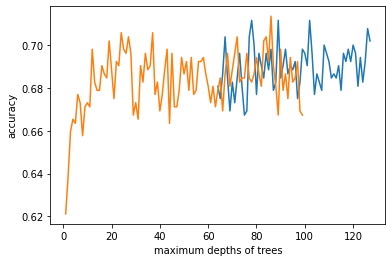

In [84]:
# Fit to random forest using w2v vectors
estimators = np.arange(64, 128, 1)
accuracies = []
cur_best_e = 0
cur_best_accu_rf = 0
best_rf = RandomForestClassifier(n_estimators=1)
for e in estimators:
  rf = RandomForestClassifier(n_estimators=e)
  rf.fit(w2v_train, label_train)
  y_p = rf.predict(w2v_test)
  accu = metrics.accuracy_score(label_test, y_p)
  accuracies.append(accu)
  if accu > cur_best_accu_rf:
    cur_best_accu_rf = accu
    cur_best_e = e
    best_rf = rf

plt.plot(estimators, accuracies)
plt.ylabel('accuracy')
plt.xlabel('number of trees in the forest')

print(cur_best_e, cur_best_accu_rf)
plt.savefig("RF_Hyperparam_e.png")
files.download("RF_Hyperparam_e.png")

depths = np.arange(1, 100, 1)
accuracies = []
cur_best_d = 0
for d in depths:
  rf = RandomForestClassifier(n_estimators=cur_best_e, max_depth=d)
  rf.fit(w2v_train, label_train)
  y_p = rf.predict(w2v_test)
  accu = metrics.accuracy_score(label_test, y_p)
  accuracies.append(accu)
  if accu > cur_best_accu_rf:
    cur_best_accu_rf = accu
    cur_best_d = d
    best_rf = rf
    
plt.plot(depths, accuracies)
plt.ylabel('accuracy')
plt.xlabel('maximum depths of trees')


print(cur_best_d, cur_best_accu_rf)
plt.savefig("RF_Hyperparam_d.png")
files.download("RF_Hyperparam_d.png")


17 0.7134615384615385


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

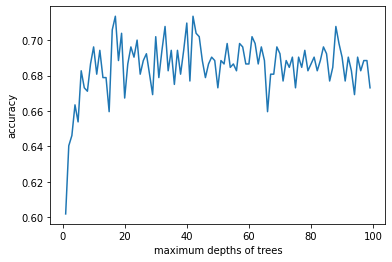

In [82]:
plt.plot(depths, accuracies)
plt.ylabel('accuracy')
plt.xlabel('maximum depths of trees')

print(cur_best_d, cur_best_accu_rf)
plt.savefig("RF_Hyperparam_d.png")
files.download("RF_Hyperparam_d.png")

In [59]:
# Fit to random forest using w2v vectors
clf_w2v_news = RandomForestClassifier(n_estimators=100)
clf_w2v_news.fit(w2v_train_news, label_train)

y_wrf_news_pred = clf_w2v_news.predict(w2v_test_news)
rfw_news_accu = metrics.accuracy_score(label_test, y_wrf_news_pred)

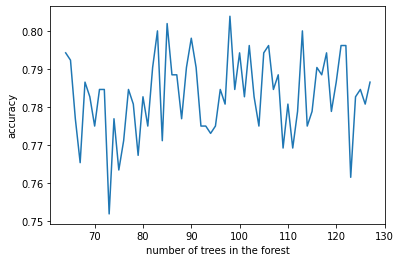

98 0.8038461538461539


In [66]:
# Fit to random forest using w2v vectors
estimators = np.arange(64, 128, 1)
accuracies = []
cur_best_e_news = 0
cur_best_accu_rf_news = 0
best_rf_news = RandomForestClassifier(n_estimators=1)
for e in estimators:
  rf = RandomForestClassifier(n_estimators=e)
  rf.fit(w2v_train_news, label_train)
  y_p = rf.predict(w2v_test_news)
  accu = metrics.accuracy_score(label_test, y_p)
  accuracies.append(accu)
  if accu > cur_best_accu_rf_news:
    cur_best_accu_rf_news = accu
    cur_best_e_news = e
    best_rf_news = rf
    
plt.plot(estimators, accuracies)
plt.ylabel('accuracy')
plt.xlabel('number of trees in the forest')
plt.show()

print(cur_best_e_news, cur_best_accu_rf_news)


### Dummy Model (zero rule)

In [61]:
# Fit to dummy (zero rule) classifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, label_train)

y_dummy_pred = dummy.predict(X_test)
dummy_accu = metrics.accuracy_score(label_test, y_dummy_pred)

## Visualization of models

In [71]:
print("Accuracies:")
print("Logistic Regression with count vec:", cur_best_accu_cv)
print("Logistic Regression with word2vec own corpus:", cur_best_accu)
print("Logistic Regression with word2vec news corpus:", cur_best_accu_news)
print()
print("Random Forest with count vec:", cur_best_accu_rf_cv)
print("Random Forest with with word2vec own corpus:", cur_best_accu_rf)
print("Random Forest with with word2vec news corpus:", cur_best_accu_rf_news)
print()
print("Zero Rule:", dummy_accu)

Accuracies:
Logistic Regression with count vec: 0.8923076923076924
Logistic Regression with word2vec own corpus: 0.5884615384615385
Logistic Regression with word2vec news corpus: 0.6923076923076923

Random Forest with count vec: 0.8807692307692307
Random Forest with with word2vec own corpus: 0.7076923076923077
Random Forest with with word2vec news corpus: 0.8038461538461539

Zero Rule: 0.5653846153846154


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

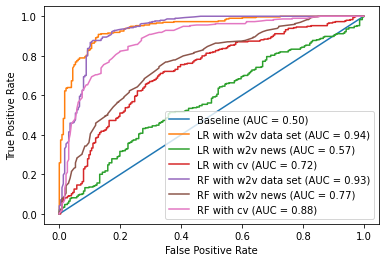

In [88]:
dum_roc = metrics.plot_roc_curve(dummy, X_test, label_test, name="Baseline")
lrcv_roc = metrics.plot_roc_curve(best_lr_cv, X_test, label_test, name="LR with w2v data set", ax=dum_roc.ax_)
lrcvw_roc = metrics.plot_roc_curve(best_lr, w2v_test, label_test, name="LR with w2v news", ax=dum_roc.ax_)
lrcvw_news_roc = metrics.plot_roc_curve(best_lr_news, w2v_test_news, label_test, name="LR with cv", ax=dum_roc.ax_)
clf_roc = metrics.plot_roc_curve(best_rf_cv, X_test, label_test, name="RF with w2v data set", ax=dum_roc.ax_)
clfw_roc = metrics.plot_roc_curve(best_rf, w2v_test, label_test, name="RF with w2v news", ax=dum_roc.ax_)
clfw_news_roc = metrics.plot_roc_curve(best_rf_news, w2v_test_news, label_test, name="RF with cv", ax=dum_roc.ax_)

plt.legend(loc="lower right")
# plt.show()
plt.savefig("ROC.png")
files.download("ROC.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

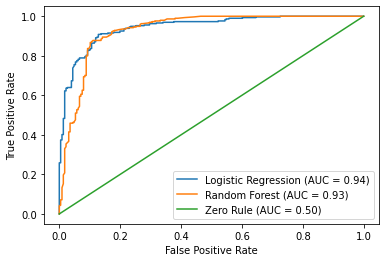

In [74]:
lrcv_roc = metrics.plot_roc_curve(best_lr_cv, X_test, label_test, name="Logistic Regression")
clf_roc = metrics.plot_roc_curve(best_rf_cv, X_test, label_test, name="Random Forest", ax=lrcv_roc.ax_)
dum_roc = metrics.plot_roc_curve(dummy, X_test, label_test, name="Zero Rule", ax=lrcv_roc.ax_)
plt.legend(loc="lower right")
# plt.show()
plt.savefig("countVec_ROC.png")
files.download("countVec_ROC.png") 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

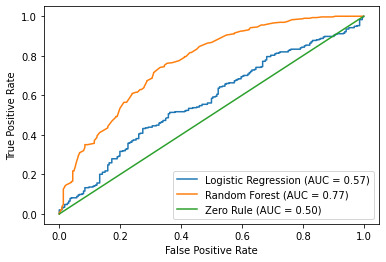

In [75]:
lrcvw_roc = metrics.plot_roc_curve(best_lr, w2v_test, label_test, name="Logistic Regression")
clfw_roc = metrics.plot_roc_curve(best_rf, w2v_test, label_test, name="Random Forest", ax=lrcvw_roc.ax_)
dum_roc = metrics.plot_roc_curve(dummy, X_test, label_test, name="Zero Rule", ax=lrcvw_roc.ax_)
plt.legend(loc="lower right")
# plt.show()
plt.savefig("w2v_own_ROC.png")
files.download("w2v_own_ROC.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

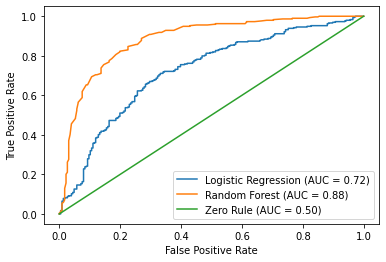

In [76]:
lrcvw_news_roc = metrics.plot_roc_curve(best_lr_news, w2v_test_news, label_test, name="Logistic Regression")
clfw_news_roc = metrics.plot_roc_curve(best_rf_news, w2v_test_news, label_test, name="Random Forest", ax=lrcvw_news_roc.ax_)
dum_roc = metrics.plot_roc_curve(dummy, X_test, label_test, name="Zero Rule", ax=lrcvw_news_roc.ax_)
plt.legend(loc="lower right")
# plt.show()
plt.savefig("w2v_news_ROC.png")
files.download("w2v_news_ROC.png") 


In [ ]:
lrcv_pc = metrics.plot_precision_recall_curve(lrcv, X_test, label_test, name="LR count")
clf_pc = metrics.plot_precision_recall_curve(clf, X_test, label_test, name="RF count", ax=lrcv_pc.ax_)
dum_pc1 = metrics.plot_precision_recall_curve(dummy, X_test, label_test, name="Zero Rule", ax=lrcv_pc.ax_)
plt.legend(loc="lower left", bbox_to_anchor=(0.1, 0.1))
plt.show()

In [ ]:
lrcvw_pc = metrics.plot_precision_recall_curve(lrcv_w2v, w2v_test, label_test, name="LR w2v")
clfw_pc = metrics.plot_precision_recall_curve(clf_w2v, w2v_test, label_test, name="RF w2v", ax=lrcvw_pc.ax_)
dum_pc2 = metrics.plot_precision_recall_curve(dummy, X_test, label_test, name="Zero Rule", ax=lrcvw_pc.ax_)
plt.legend(loc="upper right")
plt.show()

In [ ]:
lrcvw_news_pc = metrics.plot_precision_recall_curve(lrcv_w2v_news, w2v_test_news, label_test, name="LR w2v-news")
clfw_news_pc = metrics.plot_precision_recall_curve(clf_w2v_news, w2v_test_news, label_test, name="RF w2v-news", ax=lrcvw_news_pc.ax_)
dum_pc3 = metrics.plot_precision_recall_curve(dummy, X_test, label_test, name="Zero Rule", ax=lrcvw_news_pc.ax_)
plt.legend(loc="upper right")
plt.show()